In [1]:
from configure import GlobalVariable
from linecache_light import LineCache

gvar = GlobalVariable()
data_pair = LineCache('static/dataset/data_pair.json')

print gvar.arch_feats.shape
print gvar.sentence_ids.shape, gvar.sentence_ids
print data_pair.num_lines

Building prefix dict from the default dictionary ...
Loading model from cache ./jieba.cache
Loading model cost 0.214 seconds.
Prefix dict has been built succesfully.


(162944, 512)
(162944,) [    0     0     0 ..., 19206 19206 19206]
19207


In [2]:
import numpy as np
arch_feats = np.load('images.npy')
print arch_feats.shape

from torchvision import transforms
img_transform = transforms.Compose([
                transforms.Scale(100),
                transforms.CenterCrop(100),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225]),
])

(162944, 512)


In [3]:
import torch
import torch.nn as nn
from zutil.convblock import ConvBlockModule
class CNN(nn.Module):
    def __init__(self, config):
        super(CNN, self).__init__()
        self.config = config
        self.conv = ConvBlockModule(dims=[3, 16, 32, 64, 64])
        self.fc = nn.Sequential(
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
        )
        self.classifier = nn.Linear(512, 150)

    def forward(self, images):
        output = self.conv(images)
        output = output.view(self.config.batch_size, -1)
        output = self.fc(output)
        output = self.classifier(output)
        return output

    def train(self):
        self.training = True
        self.conv.train()
        self.fc.train()

    def eval(self):
        self.training = False
        self.conv.eval()
        self.fc.eval()

model = torch.load('cnn.pt')
model = nn.Sequential(*list(model.children())[:-1])
print model

Sequential (
  (0): ConvBlockModule (
    (basic_1_conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (basic_1_batchnorm): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True)
    (basic_1_relu): ReLU ()
    (basic_1_maxpool): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (basic_2_conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (basic_2_batchnorm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True)
    (basic_2_relu): ReLU ()
    (basic_2_maxpool): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (basic_3_conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (basic_3_batchnorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (basic_3_relu): ReLU ()
    (basic_3_maxpool): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (basic_4_conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (basic_4_batchnorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (basic_4_relu): ReLU ()
    (basic_4_maxpo

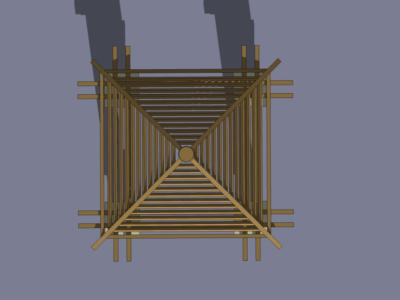

In [23]:
import json
import os
from PIL import Image

def findImgUrlByIndex(index):
    sentence_id = gvar.sentence_ids[index]
    data = json.loads(data_pair[sentence_id])
    filename = [image for image in data['images'] if image['image_id'] == index][0]['image_name'] 
    filename = os.path.join('static/dataset/' + data['poster'],filename)
    return filename

imgpath = findImgUrlByIndex(61644) # tingzi: 61644 youeryuan: 30361
img = Image.open(imgpath).convert('RGB')
img

In [24]:
from torch.autograd import Variable
img_tensor = Variable(gvar.img_transform(img).unsqueeze_(0))
output = gvar.resnet(img_tensor).squeeze().cpu().data.numpy()
print output.shape, output[0:10]

dists = np.square(gvar.arch_feats - output).sum(1)
index = dists.argsort()
dists = dists[index]

print index[0:5]

(512,) [ 1.03076994  0.15874423  0.7993505   0.12720303  1.55095327  0.09430603
  0.4659681   1.56744993  0.48640785  1.70680177]
[61644 35793 36485 36483 77624]


In [25]:
from torch.autograd import Variable
img_tensor = Variable(img_transform(img).unsqueeze_(0)).cuda(0)
output = model[1](model[0](img_tensor).view(len(img_tensor), -1))
output = output.squeeze().cpu().data.numpy()
print output.shape, output[0:10]

dists = np.square(arch_feats - output).sum(1)
index = dists.argsort()
dists = dists[index]

print index[0:5]

(512,) [ 0.          0.          0.32858261  0.          0.04823549  0.          0.0371264
  0.69633508  0.4707385   0.79371035]
[123142 100252  54447  67387 148689]


In [26]:
count = 0

92933


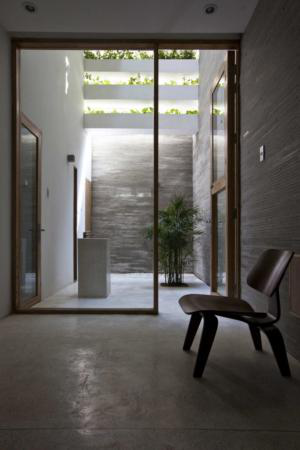

In [42]:
print index[count]
imgpath = findImgUrlByIndex(index[count])
img = Image.open(imgpath)
count += 1
img